In [1]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('Solarize_Light2')

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import xgboost as xgb
from xgboost import plot_importance, plot_tree

from datetime import timedelta
from math import sqrt
import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

from functions_air_quality_madrid import *

import os
print(os.listdir("/Users/yc00027/Documents/air-quality-madrid/"))

import warnings
warnings.filterwarnings("ignore")

['.DS_Store', 'csvs_per_year', 'stations.csv', 'madrid.h5', '.ipynb_checkpoints']


# Air quality Madrid - XGBoost

### Extracting the data

In [2]:
# Import full dataframe

df_full = pd.read_csv('full_madrid_air_quality.csv').set_index('date').sort_index()
df_full.index = pd.to_datetime(df_full.index)

# Select data for the time period, particles and stations of interest

first_date = '2012-01-01 00:00:00'
last_date = '2018-04-30 23:00:00'

particles_of_interest = ['CO', 'NO_2', 'O_3', 'SO_2']

stations_of_interest = [28079004, 28079008, 28079011, 28079016, 28079017, 28079018, 
                        28079024, 28079035, 28079036, 28079038, 28079039, 28079040]

df_temp = df_full.loc[first_date:last_date][particles_of_interest + ['station']].sort_index()
df_temp = df_temp.loc[df_temp['station'].isin(stations_of_interest)]

print(f'The time period is from {first_date} to {last_date}')
print('')

# Generate dataframe for one particle and one station of interest

particle_of_interest = 'NO_2'
station_of_interest = 28079004

print(f'The particle of interest is: {particle_of_interest}')
print('')

print(f'The station of interest is: {station_of_interest}')
print('')

oneparticle_onestation = df_temp.loc[df_temp['station'] == station_of_interest]
oneparticle_onestation = oneparticle_onestation.drop(columns = [x for x in particles_of_interest if x is not particle_of_interest], axis=1)
oneparticle_onestation.drop('station', axis=1, inplace=True)

print(f'Missing values for particle and station of interest: {round(oneparticle_onestation[particle_of_interest].isnull().mean()*100, 2)}%')
print('')
oneparticle_onestation.dropna(inplace=True)

oneparticle_onestation['diff_particle'] = oneparticle_onestation[particle_of_interest].diff()
oneparticle_onestation['bc_particle'], lamb = boxcox(oneparticle_onestation[particle_of_interest])
oneparticle_onestation['bc_diff_particle'] = oneparticle_onestation['bc_particle'].diff()
oneparticle_onestation.fillna(0, inplace=True)

oneparticle_onestation['quarter'] = oneparticle_onestation.index.quarter
oneparticle_onestation['dayofyear'] = oneparticle_onestation.index.dayofyear
oneparticle_onestation['dayofmonth'] = oneparticle_onestation.index.day
oneparticle_onestation['weekyear'] = oneparticle_onestation.index.weekofyear
oneparticle_onestation['weekday'] = oneparticle_onestation.index.weekday
oneparticle_onestation['hour'] = oneparticle_onestation.index.hour
oneparticle_onestation['year'] = oneparticle_onestation.index.year
oneparticle_onestation['month'] = oneparticle_onestation.index.month
oneparticle_onestation.fillna(0, inplace=True)

print(f'One particle, one station DF shape: {oneparticle_onestation.shape}')
oneparticle_onestation.head()

The time period is from 2012-01-01 00:00:00 to 2018-04-30 23:00:00

The particle of interest is: NO_2

The station of interest is: 28079004

Missing values for particle and station of interest: 0.34%

One particle, one station DF shape: (55302, 12)


,NO_2,diff_particle,bc_particle,bc_diff_particle,quarter,dayofyear,dayofmonth,weekyear,weekday,hour,year,month
date,,,,,,,,,,,,
2012-01-01 00:00:00,80.0,0.0,9.662568,0.000000,1,1,1,52,6,0,2012,1
2012-01-01 01:00:00,58.0,-22.0,8.402874,-1.259694,1,1,1,52,6,1,2012,1
2012-01-01 02:00:00,61.0,3.0,8.591863,0.188990,1,1,1,52,6,2,2012,1
2012-01-01 03:00:00,55.0,-6.0,8.207148,-0.384715,1,1,1,52,6,3,2012,1
2012-01-01 04:00:00,49.0,-6.0,7.792879,-0.414269,1,1,1,52,6,4,2012,1


In [3]:
# Create dataframes with rolling averages and shifts features

windows = [2, 3, 4, 5, 6, 8, 12, 24, 52]

rolling_averages_groupby_df = oneparticle_onestation.groupby(['weekday', 'hour']).apply(rolling_averages, particle_of_interest, windows)
print(rolling_averages_groupby_df.shape)

shifts_groupby_df = oneparticle_onestation.groupby(['weekday', 'hour']).apply(series_to_supervised, particle_of_interest, lags=10)
print(shifts_groupby_df.shape)

# Select features and create final dataframe

features = ['hour', 'weekday', 'month', 'year', 'quarter', 'dayofyear', 'dayofmonth', 'weekyear']
rolling_features = list(rolling_averages_groupby_df.columns)
shifts_features = list(shifts_groupby_df.columns)
all_columns = [particle_of_interest] + features + rolling_features + shifts_features

# Create new dataframe with all features from groupby

all_features_groupby_df = pd.concat([oneparticle_onestation.sort_index(), shifts_groupby_df.sort_index(), rolling_averages_groupby_df.sort_index()], axis=1)
all_features_groupby_df = all_features_groupby_df[all_columns]
print(f'All features groupby DF shape:{all_features_groupby_df.shape}')
all_features_groupby_df.head()

(55302, 9)
(55302, 10)
All features groupby DF shape:(55302, 28)


,NO_2,hour,weekday,month,year,quarter,dayofyear,dayofmonth,weekyear,NO_2 (window=2),NO_2 (window=3),NO_2 (window=4),NO_2 (window=5),NO_2 (window=6),NO_2 (window=8),NO_2 (window=12),NO_2 (window=24),NO_2 (window=52),NO_2 (t-1),NO_2 (t-2),NO_2 (t-3),NO_2 (t-4),NO_2 (t-5),NO_2 (t-6),NO_2 (t-7),NO_2 (t-8),NO_2 (t-9),NO_2 (t-10)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,80.0,0,6,1,2012,1,1,1,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01 01:00:00,58.0,1,6,1,2012,1,1,1,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01 02:00:00,61.0,2,6,1,2012,1,1,1,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01 03:00:00,55.0,3,6,1,2012,1,1,1,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01 04:00:00,49.0,4,6,1,2012,1,1,1,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Rolling XGB: target = particle_of_interest

In [4]:
# Generate rolling predictions and results for particle of interest

data = oneparticle_onestation.sort_index().copy()
target = particle_of_interest

fit_func = fit_XGB
predict_func = predict_XGB

min_train_date = '2018-01-01'
week_starts = pd.date_range(min_train_date, data.index.max(), freq='W')

predictions_over_time, results_over_time = [], []

for i, week_start in enumerate(week_starts):
    if i % 10 == 0:
        print(week_start)

    train_set = data.loc[:(week_start - timedelta(hours=1))]
    test_set = data.loc[week_start:(week_start + timedelta(weeks=1, hours=-1))]
    model = fit_func(train_set, test_set, features, target)
    predictions = predict_func(model, test_set, features)
    predictions = pd.Series(predictions, index=test_set.index)
    predictions_over_time.append(predictions)    
    results = evaluate_forecast(test_set[target], predictions, 'none')
    results['date'] = week_start
    results_over_time.append(results)  

results_over_time = pd.DataFrame(results_over_time)
predictions_over_time = pd.concat(predictions_over_time)

2018-01-07 00:00:00
[12:26:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:26:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:26:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:51] WARNING: src/objective/regression_obj.cu:

In [5]:
# Print results statistics

results_over_time.describe()

,r2_score,mean_abs_error,median_abs_error,mse,rmse
count,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.306448,14.722333,12.524746,341.048440,18.082448
std,0.139493,3.049673,2.639651,137.583056,3.866924
min,0.111587,7.809749,7.056009,76.009503,8.718343
25%,0.202947,12.724559,11.421149,244.062168,15.622489
50%,0.282836,14.629987,12.021538,333.373318,18.258514
75%,0.416614,15.668808,12.291830,415.724364,20.389320
max,0.582521,20.843485,18.079853,656.982742,25.631675


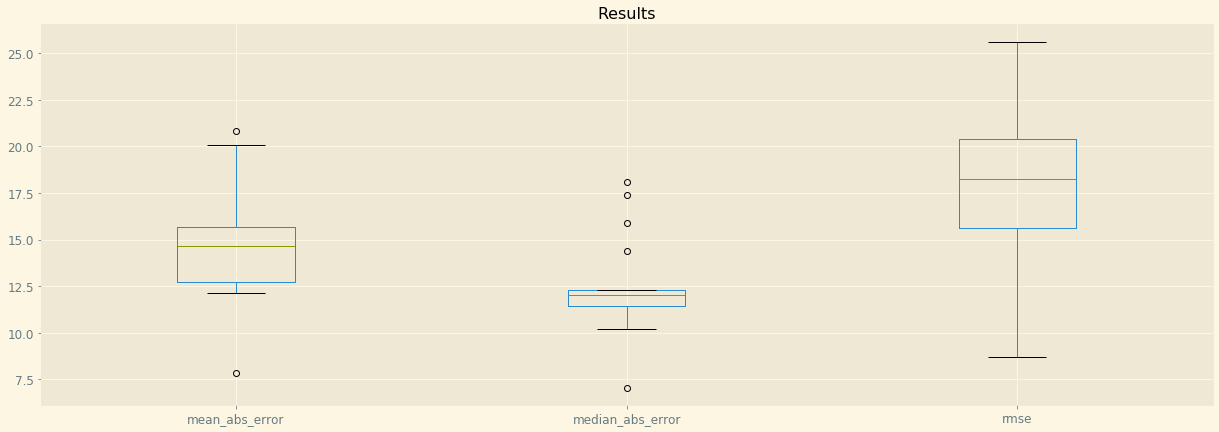

In [6]:
# Plot results statistics

fig, ax = plt.subplots(figsize=(21,7))
results_over_time.drop(['r2_score', 'mse'], axis=1).boxplot()
plt.title('Results')
plt.show()

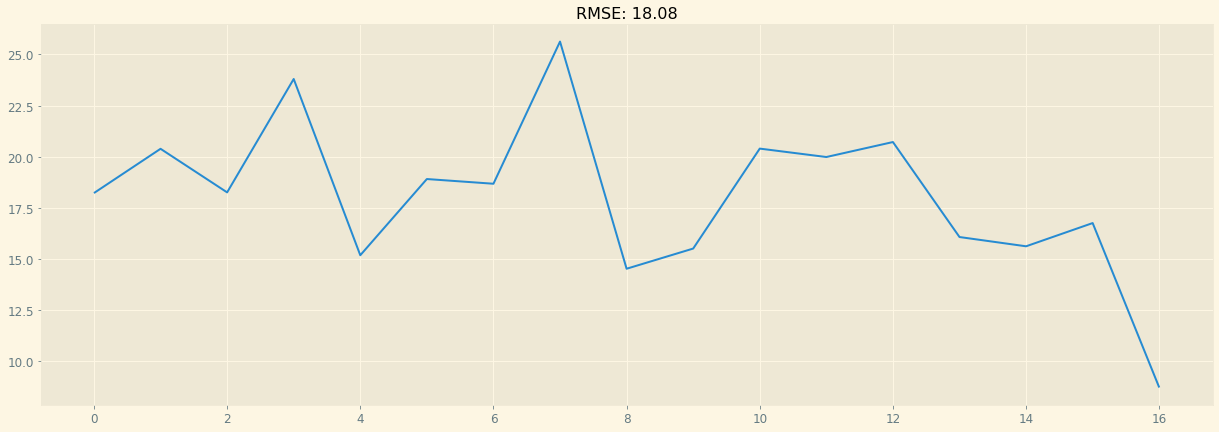

In [7]:
# Plot RMSE overtime

fig, ax = plt.subplots(figsize=(21,7))
rmse_over_time = plt.plot(results_over_time['rmse'])
error = results_over_time['rmse'].mean()
plt.title('RMSE: %.2f'% error)
plt.show()

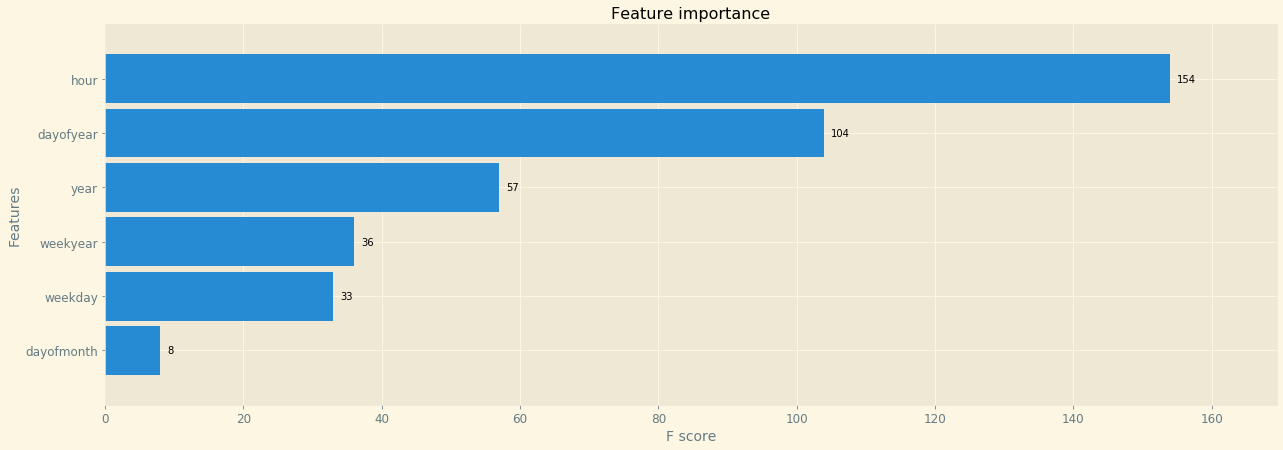

In [8]:
# Plot feature importances

fig, ax = plt.subplots(figsize=(21,7))
feature_importance = plot_importance(model, height=0.9, ax=ax)
plt.show()

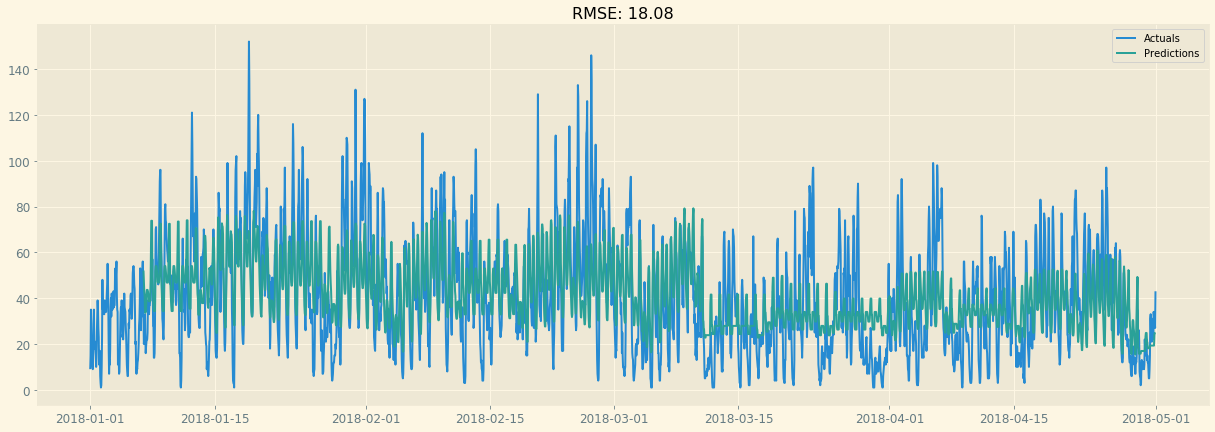

In [9]:
# Plot actuals and predictions overtime

plot_actuals_predictions(oneparticle_onestation[particle_of_interest][min_train_date:], predictions_over_time, results_over_time)

### Rolling XGB: target = particle_of_interest, with added features

In [10]:
# Generate rolling predictions and results for particle of interest

data = all_features_groupby_df.sort_index().copy()
target = particle_of_interest
all_features = [x for x in all_columns if x is not target]

fit_func = fit_XGB
predict_func = predict_XGB

min_train_date = '2018-01-01'
week_starts = pd.date_range(min_train_date, data.index.max(), freq='W')

predictions_over_time, results_over_time = [], []

for i, week_start in enumerate(week_starts):
    if i % 10 == 0:
        print(week_start)

    train_set = data.loc[:(week_start - timedelta(hours=1))]
    test_set = data.loc[week_start:(week_start + timedelta(weeks=1, hours=-1))]
    model = fit_func(train_set, test_set, all_features, target)
    predictions = predict_func(model, test_set, all_features)
    predictions = pd.Series(predictions, index=test_set.index)
    predictions_over_time.append(predictions)    
    results = evaluate_forecast(test_set[target], predictions, 'none')
    results['date'] = week_start
    results_over_time.append(results)  

results_over_time = pd.DataFrame(results_over_time)
predictions_over_time = pd.concat(predictions_over_time)

2018-01-07 00:00:00
[12:29:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:30:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:30:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:32:36] WARNING: src/objective/regression_obj.cu:

In [11]:
# Print results statistics

results_over_time.describe()

,r2_score,mean_abs_error,median_abs_error,mse,rmse
count,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.342777,14.330248,12.494533,331.958575,17.753642
std,0.121227,3.456266,3.303854,147.090017,4.220747
min,0.111003,6.700738,5.903898,65.525761,8.094798
25%,0.304959,12.277355,10.921085,235.416036,15.343273
50%,0.357255,14.755319,11.870718,332.843725,18.244005
75%,0.410241,16.214649,13.983167,399.464910,19.986618
max,0.548929,20.991694,19.448126,665.154510,25.790590


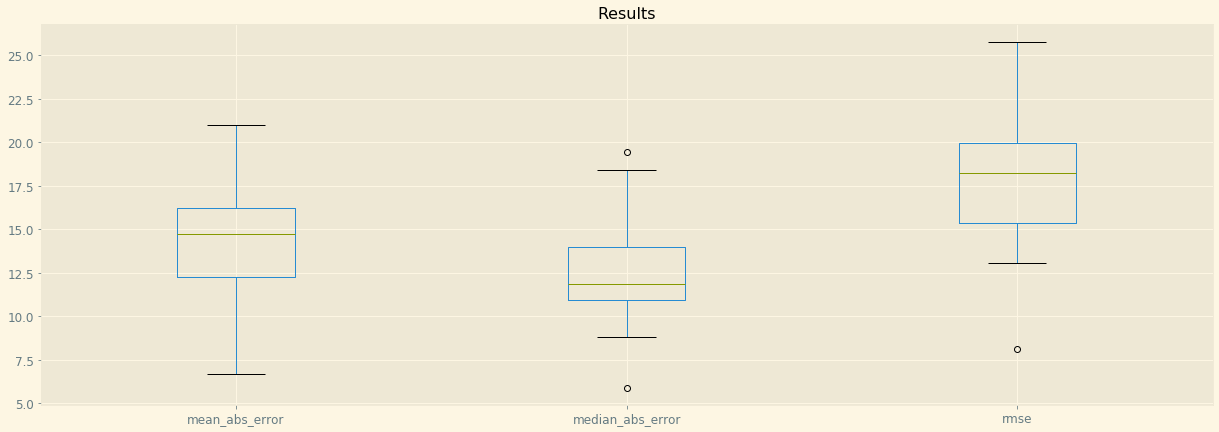

In [12]:
# Plot results statistics

fig, ax = plt.subplots(figsize=(21,7))
results_over_time.drop(['r2_score', 'mse'], axis=1).boxplot()
plt.title('Results')
plt.show()

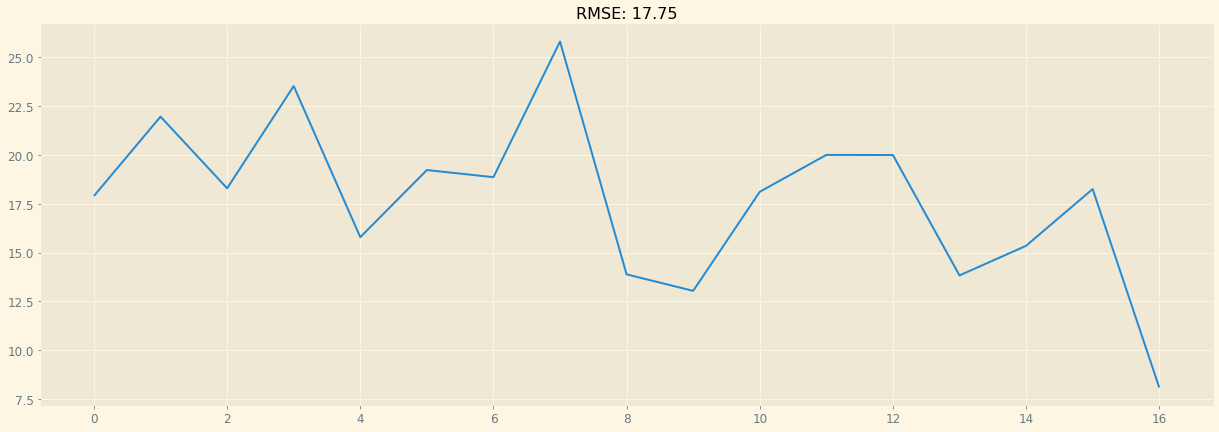

In [13]:
# Plot RMSE overtime

fig, ax = plt.subplots(figsize=(21,7))
rmse_over_time = plt.plot(results_over_time['rmse'])
error = results_over_time['rmse'].mean()
plt.title('RMSE: %.2f'% error)
plt.show()

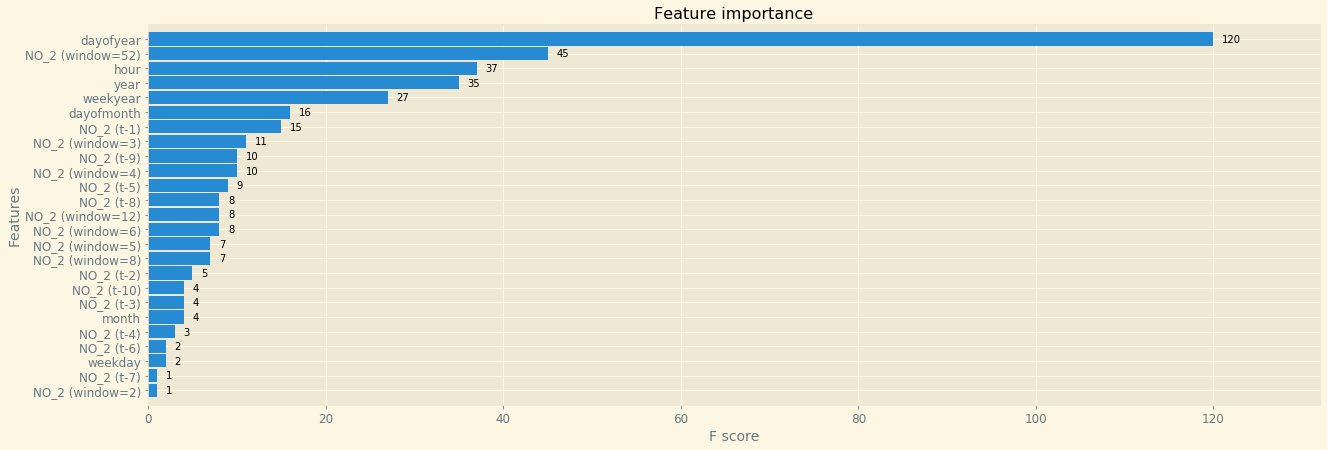

In [14]:
# Plot feature importances

fig, ax = plt.subplots(figsize=(21,7))
feature_importance = plot_importance(model, height=0.9, ax=ax)
plt.show()

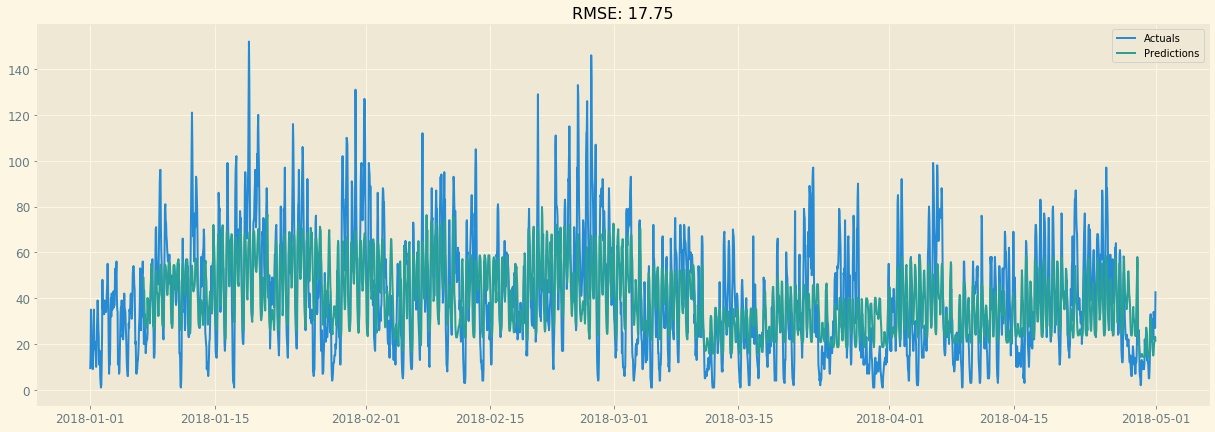

In [15]:
# Plot actuals and predictions overtime

plot_actuals_predictions(oneparticle_onestation[particle_of_interest][min_train_date:], predictions_over_time, results_over_time)